In [ ]:
# cell-collective-find-isolated-attractors.ipynb
#
# Bryan Daniels, Enrico Borriello
# 2024/1/10
#
# Find and count the number of attractors with basin size 1 in cell collective networks
# (using the preimage function).
#

In [56]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from toolbox.simplePickle import load

In [52]:
# useful code for dealing with cell collective networks from from code/cellCollective.py
def directory_name(n_name):
    """
    Returns the name of the Cell Collective directory given
    the "nice" name with spaces
    """
    return n_name.replace(' ','_').replace('.','')
    
def nice_name(dir_name):
    """
    Returns the "nice" name of the Cell Collective network
    given the directory name
    """
    nice = dir_name.replace('_',' ')
    if nice == 'Iron Acquisition And Oxidative Stress Response In Aspergillus Fumigatus':
        nice = nice+'.'
    return nice

### Load Cell Collective control kernel data from 2021 paper

In [12]:
control_kernel_data_file = '/Users/bdaniel6/ASUDropbox/Research/grn-survey/Writeups/control-kernel-2020/'\
    'Nature Comm final revision Aug 2021/zenodo Aug 2021/20200820_control_kernel_supplemental_info.csv'
ck_df = pd.read_csv(control_kernel_data_file).set_index('name')

# include expected average ck size and difference from expected
ck_df['expected mean control kernel size'] = np.log2(ck_df['number of attractors'])
ck_df['difference from expected mean control kernel size'] = \
    ck_df['mean control kernel size'] - ck_df['expected mean control kernel size']

print("We have exact control kernel data for {} networks.".format((1-ck_df['uses sampling method']).sum()))

We have exact control kernel data for 44 networks.


### Load basin data from newer Cell Collective runs

In [5]:
datadir = '../code/'

In [6]:
# concatenate all csv file data
df_list = []
for filename in glob.glob(datadir+'basin_entropy_data*.csv'):
    df_single = pd.read_csv(filename)
    df_list.append(df_single)
df = pd.concat(df_list).set_index('name')
#df = df.apply(pd.to_numeric,errors='coerce')
# make everything numeric except for "elapsed_time"
numeric_cols = df.columns[df.columns != 'elapsed_time']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric,errors='coerce')
df.head()

,network_size,num_states,num_samples,num_attractors,basin_entropy_NSB,std_basin_entropy_NSB,elapsed_time
name,,,,,,,
Budding_Yeast_Cell_Cycle,20,1048576,10000,33,4.692749,0.008449,0:00:18.083787
Mammalian_Cell_Cycle,20,1048576,10000,3,1.014787,0.003261,0:00:02.020575
HCC1954_Breast_Cell_Line_Long-term_ErbB_Network,25,33554432,10000,9452,8.269992,0.021576,0:11:16.461616
Cortical_Area_Development,5,32,10000,2,0.568464,0.155180,0:00:00.808031
B_Cell_Differentiation,22,4194304,10000,61,5.440223,0.008863,0:00:04.590949


In [9]:
# gather all detailed basin data into a dictionary
basinDataDict = {}
for name in df.index:
    data = load('{}basin_entropy_data_{}.pkl'.format(datadir,name))
    basinDataDict[name] = data

### Load all Cell Collective networks into Neet

In [16]:
# from cellCollective.py
from neet.boolean import LogicNetwork
import os
def load_cell_collective_network(directory):
    """
    Creates neet network from cell collective data in the
    given directory.
    """
    expressions_file = '{}/expressions.txt'.format(directory)
    external_file = '{}/external.txt'.format(directory)
    net = LogicNetwork.read_logic(expressions_file, external_file)
    return net

def load_all_cell_collective_networks(main_directory,
    skip=['ErbB_Receptor_Signaling']):
    """
    Returns dictionary of all cell collective networks
    located in subdirectories of the given main directory.
    
    skip (['ErbB_Receptor_Signaling']) : List of network names
                                         to skip
    """
    netDict = {}
    for directory in glob.glob(main_directory+"/*"):
        name = os.path.split(directory)[-1]
        if os.path.isdir(directory) and name not in skip:
            net = load_cell_collective_network(directory)
            netDict[name] = net
    return netDict

In [17]:
CELL_COLLECTIVE_DIR = '/Users/bdaniel6/ASUDropbox/Research/control-continuous/Data/Cell Collective/'
netDict = load_all_cell_collective_networks(CELL_COLLECTIVE_DIR)

# Find all isolated attractors in each analyzed network

In [40]:
import preimages
import importlib
importlib.reload(preimages)
import tqdm

In [20]:
basinDataDict['Cortical_Area_Development']

{'name': 'Cortical_Area_Development',
 'network_size': 5,
 'num_states': 32,
 'attractors': array([[ 3],
        [28]]),
 'num_attractors': 2,
 'num_samples': 10000,
 'sampled_basin_freqs': [28, 4],
 'basin_entropy_NSB': 0.5684643218360583,
 'std_basin_entropy_NSB': 0.1551796050704989,
 'elapsed_time': datetime.timedelta(microseconds=808031)}

In [47]:
def isolated_list(net,attractors,basin_samples=None):
    """
    Returns a list of Boolean values of length number of attractors
    corresponding to whether each attractor is "isolated"
    (has basin of size 1).
    
    basin_samples (None)        : Optionally give list of basin samples to avoid computing
                                  preimages of attractors that we already know are not isolated.
    """
    if basin_samples is None:
        basin_samples = np.zeros(len(attractors))
    assert(len(attractors)==len(basin_samples))
    
    is_isolated_list = []
    for i,att in enumerate(tqdm.tqdm(attractors)):
        if len(att) > 1 or basin_samples[i] > 1:
            is_isolated_list.append(False)
        else:
            decoded_att = net.decode(att[0])
            is_isolated_list.append(len(preimages.preimages(net,decoded_att))==1)
    return is_isolated_list

In [48]:
net_name = 'Cortical_Area_Development'

net = netDict[net_name]
isolated_list(net,
              basinDataDict[net_name]['attractors'],
              basinDataDict[net_name]['sampled_basin_freqs'])

100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 1539.76it/s]


[False, False]

In [49]:
for net_name in basinDataDict:
    print("Computing for network {}...".format(net_name))
    net = netDict[net_name]
    is_isolated_list = isolated_list(net,
                                     basinDataDict[net_name]['attractors'],
                                     basinDataDict[net_name]['sampled_basin_freqs'])
    basinDataDict[net_name]['is_isolated_list'] = is_isolated_list

Computing for network Budding_Yeast_Cell_Cycle...


100%|███████████████████████████████████████| 33/33 [00:00<00:00, 178366.02it/s]


Computing for network Mammalian_Cell_Cycle...


100%|██████████████████████████████████████████| 3/3 [00:00<00:00, 33288.13it/s]


Computing for network HCC1954_Breast_Cell_Line_Long-term_ErbB_Network...


100%|███████████████████████████████████████| 9452/9452 [06:12<00:00, 25.38it/s]


Computing for network Cortical_Area_Development...


100%|██████████████████████████████████████████| 2/2 [00:00<00:00, 55553.70it/s]


Computing for network B_Cell_Differentiation...


100%|██████████████████████████████████████| 61/61 [00:00<00:00, 1031663.48it/s]


Computing for network Predicting_Variabilities_In_Cardiac_Gene...


100%|█████████████████████████████████████████| 6/6 [00:00<00:00, 186413.51it/s]


Computing for network Pro-inflammatory_Tumor_Microenvironment_In_Acute_Lymphoblastic_Leukemia...


100%|█████████████████████████████████████████| 6/6 [00:00<00:00, 147168.56it/s]


Computing for network T-LGL_Survival_Network_2011_Reduced_Network...


100%|██████████████████████████████████████████| 3/3 [00:00<00:00, 99864.38it/s]


Computing for network Processing_Of_Spz_Network_From_The_Drosophila_Signaling_Pathway...


100%|██████████████████████████████████████| 64/64 [00:00<00:00, 1123160.90it/s]


Computing for network Neurotransmitter_Signaling_Pathway...


100%|██████████████████████████████████████████| 4/4 [00:00<00:00, 98112.37it/s]


Computing for network Toll_Pathway_Of_Drosophila_Signaling_Pathway...


100%|██████████████████████████████████████████| 4/4 [00:00<00:00, 33420.75it/s]


Computing for network Regulation_Of_The_L-arabinose_Operon_Of_Escherichia_Coli...


100%|███████████████████████████████████████| 21/21 [00:00<00:00, 276114.06it/s]


Computing for network FGF_Pathway_Of_Drosophila_Signalling_Pathways...


100%|████████████████████████████████████| 512/512 [00:00<00:00, 1952257.86it/s]


Computing for network Vegf_Pathway_Of_Drosophila_Signaling_Pathway...


100%|████████████████████████████████████| 256/256 [00:00<00:00, 1754480.10it/s]


Computing for network Cell_Cycle_Transcription_By_Coupled_CDK_And_Network_Oscillators...


100%|██████████████████████████████████████████| 2/2 [00:00<00:00, 62601.55it/s]


Computing for network Iron_Acquisition_And_Oxidative_Stress_Response_In_Aspergillus_Fumigatus...


100%|██████████████████████████████████████████| 4/4 [00:00<00:00, 93206.76it/s]


Computing for network Wg_Pathway_Of_Drosophila_Signalling_Pathways...


100%|█████████████████████████████████████| 16384/16384 [10:02<00:00, 27.17it/s]


Computing for network Oxidative_Stress_Pathway...


100%|██████████████████████████████████████████| 2/2 [00:00<00:00, 42366.71it/s]


Computing for network Metabolic_Interactions_In_The_Gut_Microbiome...


100%|███████████████████████████████████████| 40/40 [00:00<00:00, 864804.95it/s]


Computing for network CD4+_T_Cell_Differentiation_And_Plasticity...


100%|█████████████████████████████████████████| 324/324 [00:04<00:00, 80.88it/s]


Computing for network TOL_Regulatory_Network...


100%|██████████████████████████████████| 1024/1024 [00:00<00:00, 2380802.27it/s]


Computing for network HCC1954_Breast_Cell_Line_Short-term_ErbB_Network...


100%|████████████████████████████████████████| 274/274 [00:01<00:00, 173.52it/s]


Computing for network BT474_Breast_Cell_Line_Long-term_ErbB_Network...


100%|███████████████████████████████████████| 3344/3344 [01:56<00:00, 28.74it/s]


Computing for network Trichostrongylus_Retortaeformis...


100%|███████████████████████████████████████| 12/12 [00:00<00:00, 324720.31it/s]


Computing for network Body_Segmentation_In_Drosophila_2013...


100%|███████████████████████████████████████| 10/10 [00:00<00:00, 223101.28it/s]


Computing for network Lac_Operon...


100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 184140.18it/s]


Computing for network Death_Receptor_Signaling...


100%|██████████████████████████████████████████| 97/97 [00:00<00:00, 273.57it/s]


Computing for network SKBR3_Breast_Cell_Line_Long-term_ErbB_Network...


100%|███████████████████████████████████████| 3185/3185 [02:08<00:00, 24.77it/s]


Computing for network T_Cell_Differentiation...


100%|███████████████████████████████████████| 33/33 [00:00<00:00, 748173.15it/s]


Computing for network Cardiac_Development...


100%|█████████████████████████████████████████| 6/6 [00:00<00:00, 150693.56it/s]


Computing for network Human_Gonadal_Sex_Determination...


100%|██████████████████████████████████████████| 3/3 [00:00<00:00, 93206.76it/s]


Computing for network HH_Pathway_Of_Drosophila_Signaling_Pathways...


100%|███████████████████████████████████████| 8192/8192 [07:38<00:00, 17.86it/s]


Computing for network SKBR3_Breast_Cell_Line_Short-term_ErbB_Network...


100%|█████████████████████████████████████████| 702/702 [00:08<00:00, 84.02it/s]


Computing for network BT474_Breast_Cell_Line_Short-term_ErbB_Network...


100%|████████████████████████████████████████| 253/253 [00:01<00:00, 135.58it/s]


In [53]:
# compuate number of isolated fixed points for each network
for net_name in basinDataDict:
    ck_df.loc[nice_name(net_name),'number of isolated fixed points'] = \
        np.sum(basinDataDict[net_name]['is_isolated_list'])

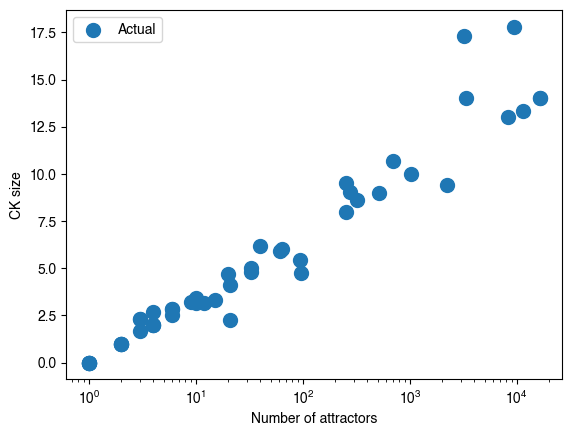

In [62]:
r = ck_df['number of attractors']
s = ck_df['number of isolated fixed points']
n = ck_df['size']
predicted_ck = (r - s)/(r)*np.log2(r) + n*s/r
actual_ck = ck_df['mean control kernel size']
plt.scatter(r,actual_ck,label='Actual',s=100)
#plt.scatter(r,predicted_ck,label='Predicted')

plt.xlabel('Number of attractors')
plt.ylabel('CK size')
plt.legend()
plt.xscale('log')

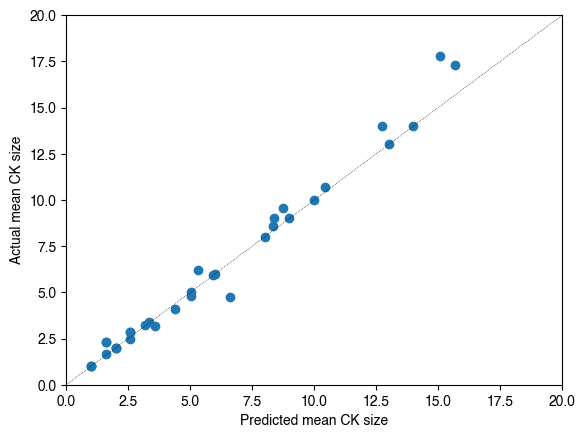

In [68]:
plt.scatter(predicted_ck,actual_ck)
plt.xlabel('Predicted mean CK size')
plt.ylabel('Actual mean CK size')
sizemin,sizemax = 0,20
plt.plot([sizemin,sizemax],[sizemin,sizemax],'k:',lw=0.5)
plt.axis([sizemin,sizemax,sizemin,sizemax])
plt.savefig('240110_actual_versus_predicted_mean_ck_size.pdf')